In [ ]:
!pip install rouge_score -q
!pip install bert_score -q

from google.colab import drive
drive.mount('/content/drive')

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import re
from rouge_score import rouge_scorer
from bert_score import score
import torch


curated_bart = pd.read_csv('/content/drive/MyDrive/Dissertation/bart/curated_bart.csv')
pilot_bart = pd.read_csv('/content/drive/MyDrive/Dissertation/bart/pilot_bart.csv')


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100


In [ ]:
print("\n Loading BART results...")


curated_bart = pd.read_csv('/content/drive/MyDrive/Dissertation/bart/curated_bart.csv')
pilot_bart = pd.read_csv('/content/drive/MyDrive/Dissertation/bart/pilot_bart.csv')

print(f"✓ Loaded curated: {len(curated_bart)} excerpts")
print(f"✓ Loaded pilot: {len(pilot_bart)} excerpts")


📊 Loading BART results...
✓ Loaded curated: 132 excerpts
✓ Loaded pilot: 351 excerpts


In [ ]:
def define_linguistic_patterns():
    """Define regex patterns for linguistic features"""

    patterns = {
        'hedges': r'\b(I think|I believe|maybe|perhaps|possibly|probably|seems?|appear(?:s|ed)?|'
                 r'kind of|sort of|somewhat|quite|rather|fairly|pretty much|basically|actually|'
                 r'I guess|I suppose|presumably|apparently|arguably|conceivably|'
                 r'in my opinion|if I recall|as far as I know|to my knowledge)\b',

        'modals': r'\b(might|may|could|would|should|must|ought to|'
                 r'can|cannot|can\'t|couldn\'t|wouldn\'t|shouldn\'t|'
                 r'shall|will|won\'t|mightn\'t|mayn\'t)\b',

        'conditionals': r'\b(if|unless|provided that|assuming|supposing|whether|'
                       r'in case|as long as|even if|only if|were|had|should)\b',

        'temporals': r'\b(before|after|during|while|when|then|at that time|at the time|'
                    r'previously|subsequently|meanwhile|simultaneously|eventually|'
                    r'back then|later on|earlier|afterwards|prior to|following)\b',

        'disfluencies': r'\b(um+|uh+|er+|ah+|mm+|hm+|hmm+)\b|'
                       r'\b(\w+)-\1\b|'  # Repetitions like "I-I"
                       r'\b(\w+)\s+\1\b(?!\w)|'  # Word repetitions
                       r'\.\.\.|—|--'  # Pauses
    }

    return patterns

def count_features(text, patterns):
    """Count linguistic features in text"""

    if pd.isna(text) or not text or text == 'nan':
        return {cat: 0 for cat in list(patterns.keys()) + ['total']}

    text = str(text)
    counts = {}

    for category, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        counts[category] = len(matches)

    counts['total'] = sum(counts.values())
    return counts

patterns = define_linguistic_patterns()

In [ ]:

print("Columns in pilot_bart:", pilot_bart.columns.tolist())
print("First row:", pilot_bart.iloc[0])

Columns in pilot_bart: ['ID', 'SPEAKER', 'Excerpt', 'LING_FEATURES', 'bart_summary']
First row: ID                                                            T118
SPEAKER                                                          A
Excerpt          I couldn't vote on the motions if I hadn't see...
LING_FEATURES                                    cond_unreal, temp
bart_summary     I couldn't vote on the motions if I hadn't see...
Name: 0, dtype: object


In [ ]:
print("\n📊 CALCULATING METRICS FOR CURATED DATASET...")
print("-"*40)

def calculate_all_metrics(df, original_col, summary_col='bart_summary'):
    """Calculate all preservation and quality metrics"""

    retention_results = {
        'hedges': [], 'modals': [], 'conditionals': [],
        'temporals': [], 'disfluencies': [], 'overall': []
    }

    complete_loss_count = 0
    total_with_features = 0
    disfluency_sanitization_rates = []
    certainty_inflation_count = 0
    compression_ratios = []
    verbatim_copy_count = 0

    for idx, row in df.iterrows():
        original = str(row[original_col])
        summary = str(row[summary_col])

        if original.strip() == summary.strip() or original.strip()[:200] == summary.strip()[:200]:
            verbatim_copy_count += 1

        orig_counts = count_features(original, patterns)
        summ_counts = count_features(summary, patterns)

        # Feature Retention Rates
        for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
            if orig_counts[feature] > 0:
                retention = min(summ_counts[feature] / orig_counts[feature], 1.0)
            else:
                retention = 1.0
            retention_results[feature].append(retention)

        # Overall retention
        if orig_counts['total'] > 0:
            overall = min(summ_counts['total'] / orig_counts['total'], 1.0)
            retention_results['overall'].append(overall)

            total_with_features += 1
            if summ_counts['total'] == 0:
                complete_loss_count += 1
        else:
            retention_results['overall'].append(1.0)

        # Disfluency Sanitization
        if orig_counts['disfluencies'] > 0:
            retained = min(summ_counts['disfluencies'] / orig_counts['disfluencies'], 1.0)
            sanitization = (1 - retained) * 100
            disfluency_sanitization_rates.append(sanitization)
        else:
            disfluency_sanitization_rates.append(0)

        # Certainty Inflation (simple check)
        if 'I think' in original.lower() and 'I think' not in summary.lower():
            certainty_inflation_count += 1

        # Compression Ratio
        orig_words = len(original.split())
        summ_words = len(summary.split())
        if orig_words > 0:
            compression = (summ_words / orig_words) * 100
            compression_ratios.append(compression)
        else:
            compression_ratios.append(0)

    # Calculate means
    results = {}
    for feature in retention_results:
        results[f'{feature}_retention'] = np.mean(retention_results[feature]) * 100

    results['complete_loss'] = (complete_loss_count / total_with_features * 100) if total_with_features > 0 else 0
    results['disfluency_sanitization'] = np.mean(disfluency_sanitization_rates)
    results['certainty_inflation'] = certainty_inflation_count
    results['compression_ratio'] = np.mean(compression_ratios)
    results['verbatim_copy_rate'] = (verbatim_copy_count / len(df)) * 100

    return results

# Calculate for Curated
print("\nCurated BART:")
curated_results = calculate_all_metrics(curated_bart, 'Excerpt')
print(f"  Feature Retention Rates:")
for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
    print(f"    {feature}: {curated_results[f'{feature}_retention']:.1f}%")
print(f"    overall: {curated_results['overall_retention']:.1f}%")
print(f"  Certainty Inflation: {curated_results['certainty_inflation']} instances")
print(f"  Disfluency Sanitization Rate: {curated_results['disfluency_sanitization']:.1f}%")
print(f"  Complete Feature Loss: {curated_results['complete_loss']:.1f}%")
print(f"  Compression Ratio: {curated_results['compression_ratio']:.1f}%")
print(f"  Verbatim Copy Rate: {curated_results['verbatim_copy_rate']:.1f}%")

# Calculate for Pilot
print("\n CALCULATING METRICS FOR PILOT DATASET...")
print("-"*40)
print("\nPilot BART:")
pilot_results = calculate_all_metrics(pilot_bart, 'Excerpt')
print(f"  Feature Retention Rates:")
for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
    print(f"    {feature}: {pilot_results[f'{feature}_retention']:.1f}%")
print(f"    overall: {pilot_results['overall_retention']:.1f}%")
print(f"  Certainty Inflation: {pilot_results['certainty_inflation']} instances")
print(f"  Disfluency Sanitization Rate: {pilot_results['disfluency_sanitization']:.1f}%")
print(f"  Complete Feature Loss: {pilot_results['complete_loss']:.1f}%")
print(f"  Compression Ratio: {pilot_results['compression_ratio']:.1f}%")
print(f"  Verbatim Copy Rate: {pilot_results['verbatim_copy_rate']:.1f}%")

print("\n" + "="*60)



📊 CALCULATING METRICS FOR CURATED DATASET...
----------------------------------------

Curated BART:
  Feature Retention Rates:
    hedges: 93.6%
    modals: 92.3%
    conditionals: 97.5%
    temporals: 95.1%
    disfluencies: 94.4%
    overall: 90.6%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Rate: 5.6%
  Complete Feature Loss: 2.9%
  Compression Ratio: 227.7%
  Verbatim Copy Rate: 14.4%

📊 CALCULATING METRICS FOR PILOT DATASET...
----------------------------------------

Pilot BART:
  Feature Retention Rates:
    hedges: 96.5%
    modals: 95.7%
    conditionals: 94.3%
    temporals: 94.3%
    disfluencies: 92.2%
    overall: 92.1%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Rate: 7.8%
  Complete Feature Loss: 4.6%
  Compression Ratio: 371.0%
  Verbatim Copy Rate: 12.8%



In [ ]:
def calculate_rouge_l(df, reference_col, summary_col='bart_summary'):
    """Calculate ROUGE-L scores"""
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = []

    for idx, row in df.iterrows():
        reference = str(row[reference_col])
        summary = str(row[summary_col])

        if pd.isna(summary) or summary == 'nan' or not summary:
            rouge_scores.append(0)
            continue

        scores = scorer.score(reference, summary)
        rouge_scores.append(scores['rougeL'].fmeasure)

    return np.mean(rouge_scores) * 100, np.std(rouge_scores) * 100

def calculate_bertscore(df, reference_col, summary_col='bart_summary', batch_size=16):
    """Calculate BERTScore"""
    references = []
    summaries = []

    for idx, row in df.iterrows():
        reference = str(row[reference_col])
        summary = str(row[summary_col])

        if pd.isna(summary) or summary == 'nan' or not summary:
            summary = ""

        references.append(reference)
        summaries.append(summary)

    P, R, F1 = score(summaries, references,
                     lang='en',
                     model_type='microsoft/deberta-base-mnli',
                     batch_size=batch_size,
                     verbose=False,
                     device='cuda' if torch.cuda.is_available() else 'cpu')

    bertscore_f1 = F1.numpy() * 100
    return np.mean(bertscore_f1), np.std(bertscore_f1)

print("\n📈 Curated BART:")
cur_rouge_mean, cur_rouge_std = calculate_rouge_l(curated_bart, 'Excerpt')
print(f"  ROUGE-L: {cur_rouge_mean:.1f}% (±{cur_rouge_std:.1f}%)")

print("  Calculating BERTScore... (this may take a moment)")
try:
    cur_bert_mean, cur_bert_std = calculate_bertscore(curated_bart, 'Excerpt')
    print(f"  BERTScore F1: {cur_bert_mean:.1f}% (±{cur_bert_std:.1f}%)")
except:
    cur_bert_mean = 0
    print("  BERTScore: Could not calculate")

curated_results['rouge_l'] = cur_rouge_mean
curated_results['bertscore'] = cur_bert_mean

print("\n📊 CALCULATING QUALITY METRICS FOR PILOT DATASET...")
print("-"*50)

print("\n📈 Pilot BART:")
pilot_rouge_mean, pilot_rouge_std = calculate_rouge_l(pilot_bart, 'Excerpt')
print(f"  ROUGE-L: {pilot_rouge_mean:.1f}% (±{pilot_rouge_std:.1f}%)")

print("  Calculating BERTScore... (this may take a moment)")
try:
    pilot_bert_mean, pilot_bert_std = calculate_bertscore(pilot_bart, 'Excerpt')
    print(f"  BERTScore F1: {pilot_bert_mean:.1f}% (±{pilot_bert_std:.1f}%)")
except:
    pilot_bert_mean = 0
    print("  BERTScore: Could not calculate")

pilot_results['rouge_l'] = pilot_rouge_mean
pilot_results['bertscore'] = pilot_bert_mean


📊 CALCULATING QUALITY METRICS FOR CURATED DATASET...
--------------------------------------------------

📈 Curated BART:
  ROUGE-L: 69.1% (±24.8%)
  Calculating BERTScore... (this may take a moment)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

  BERTScore F1: 83.7% (±12.0%)

📊 CALCULATING QUALITY METRICS FOR PILOT DATASET...
--------------------------------------------------

📈 Pilot BART:
  ROUGE-L: 55.8% (±28.1%)
  Calculating BERTScore... (this may take a moment)
  BERTScore F1: 69.6% (±17.0%)



CREATING VISUALIZATIONS (SAME FORMAT AS EXTRACTIVE/PEGASUS)


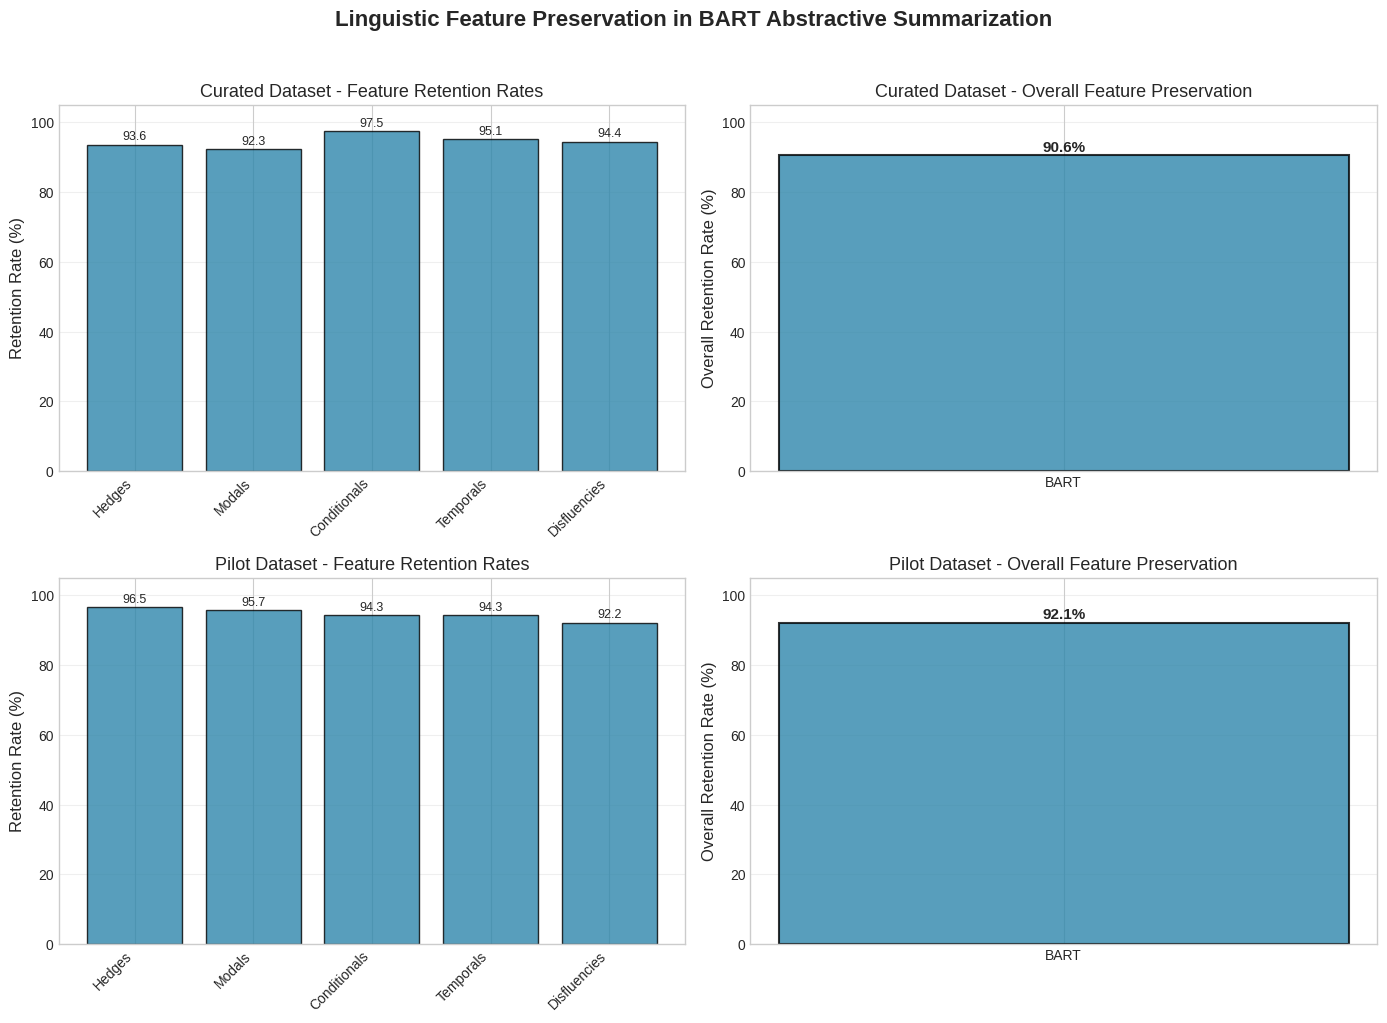

✓ Saved: bart_feature_retention.png


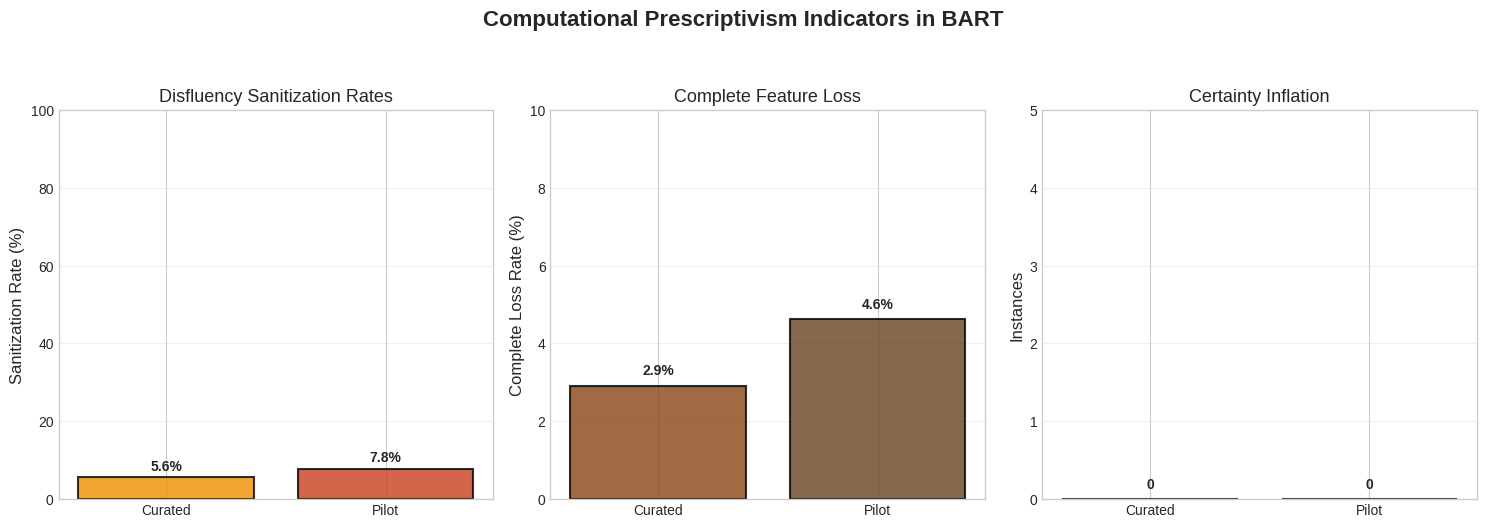

✓ Saved: bart_prescriptivism_indicators.png


/tmp/ipython-input-2022025304.py:202: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


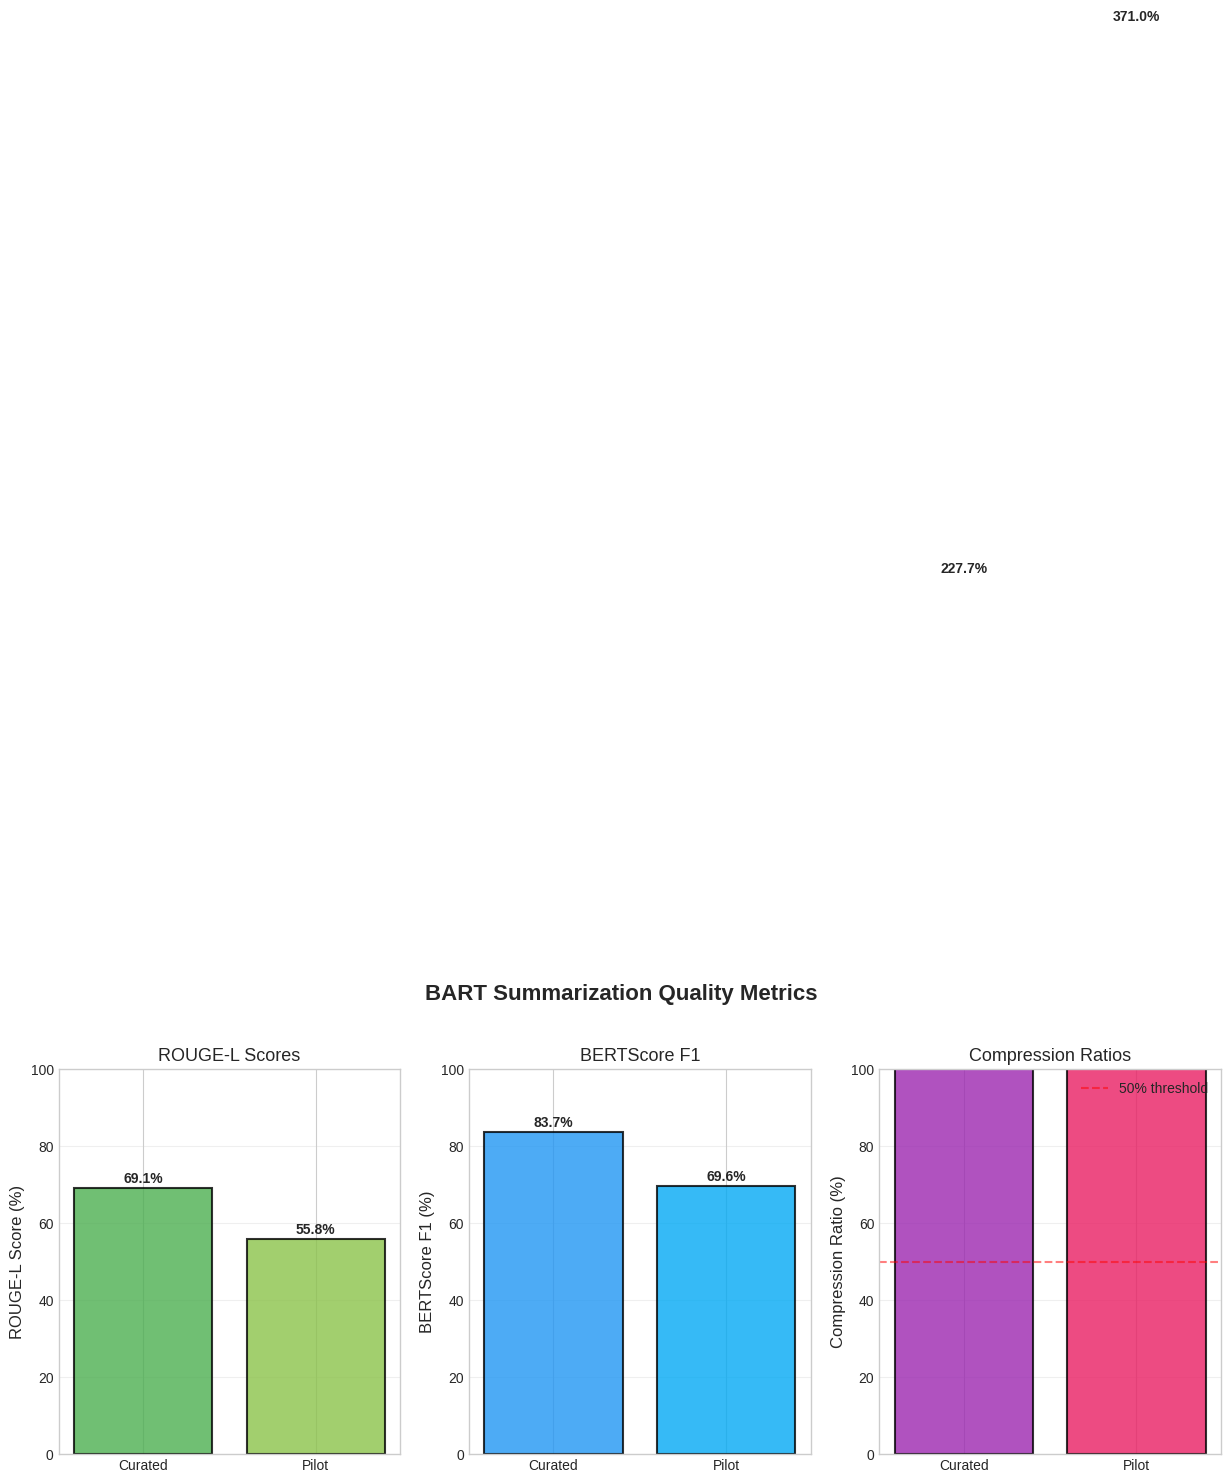

✓ Saved: bart_quality_metrics.png


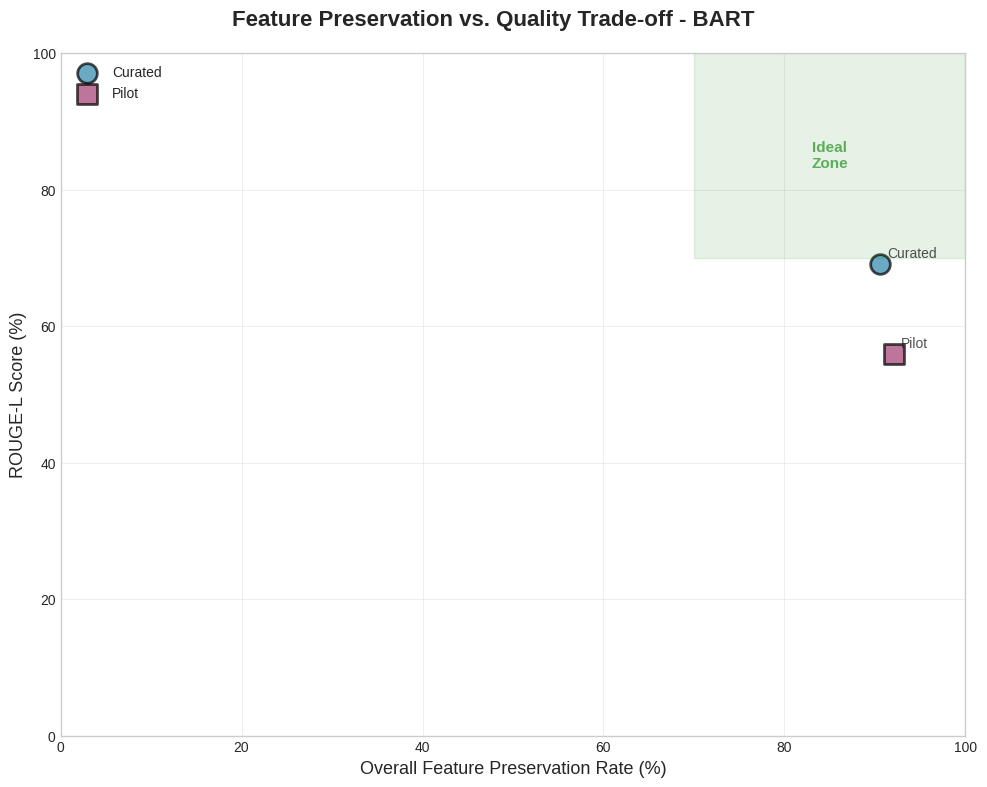

✓ Saved: bart_preservation_quality_tradeoff.png

BART-SPECIFIC BEHAVIOR: EXTRACTIVE TENDENCY


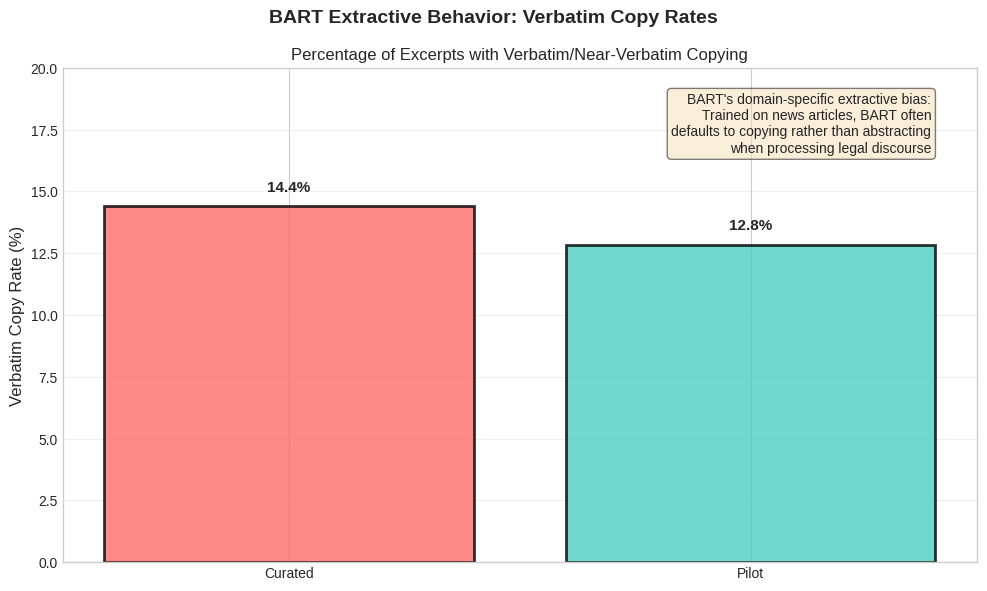

✓ Saved: bart_extractive_behavior.png

✅ All Section 3.4 metrics calculated!
✅ All visualizations created with exact same format!

Key BART Findings:
• High feature preservation: 91.3%
• Low complete loss: 3.8%
• Minimal certainty inflation: 0 total instances
• Extractive tendency: 13.6% verbatim copying

BART shows domain-specific extractive bias - preserving features through copying rather than abstraction


In [ ]:


print("\n" + "="*60)
print("CREATING VISUALIZATIONS (SAME FORMAT AS EXTRACTIVE/PEGASUS)")
print("="*60)


fig1, axes = plt.subplots(2, 2, figsize=(14, 10))
fig1.suptitle('Linguistic Feature Preservation in BART Abstractive Summarization',
              fontsize=16, fontweight='bold', y=1.02)

features = ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']
feature_labels = ['Hedges', 'Modals', 'Conditionals', 'Temporals', 'Disfluencies']


ax = axes[0, 0]
bart_values = [curated_results[f'{f}_retention'] for f in features]
x = np.arange(len(features))
bars = ax.bar(x, bart_values, color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1)
ax.set_ylabel('Retention Rate (%)', fontsize=12)
ax.set_title('Curated Dataset - Feature Retention Rates', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(feature_labels, rotation=45, ha='right')
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
           f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Curated - Overall retention
ax = axes[0, 1]
overall = curated_results['overall_retention']
bar = ax.bar(['BART'], [overall], color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Overall Retention Rate (%)', fontsize=12)
ax.set_title('Curated Dataset - Overall Feature Preservation', fontsize=13)
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)
ax.text(bar[0].get_x() + bar[0].get_width()/2., overall + 0.3,
       f'{overall:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pilot dataset - Feature retention
ax = axes[1, 0]
bart_values = [pilot_results[f'{f}_retention'] for f in features]
bars = ax.bar(x, bart_values, color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1)
ax.set_ylabel('Retention Rate (%)', fontsize=12)
ax.set_title('Pilot Dataset - Feature Retention Rates', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(feature_labels, rotation=45, ha='right')
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
           f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# Pilot - Overall retention
ax = axes[1, 1]
overall = pilot_results['overall_retention']
bar = ax.bar(['BART'], [overall], color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Overall Retention Rate (%)', fontsize=12)
ax.set_title('Pilot Dataset - Overall Feature Preservation', fontsize=13)
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)
ax.text(bar[0].get_x() + bar[0].get_width()/2., overall + 0.3,
       f'{overall:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/bart/bart_feature_retention.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: bart_feature_retention.png")

# FIGURE 2: Prescriptivism Indicators (EXACT SAME AS EXTRACTIVE/PEGASUS)
fig2, axes = plt.subplots(1, 3, figsize=(15, 5))
fig2.suptitle('Computational Prescriptivism Indicators in BART',
              fontsize=16, fontweight='bold', y=1.05)

# Disfluency Sanitization
ax1 = axes[0]
sanitization_data = {
    'Curated': curated_results['disfluency_sanitization'],
    'Pilot': pilot_results['disfluency_sanitization']
}
bars = ax1.bar(sanitization_data.keys(), sanitization_data.values(),
               color=['#F18F01', '#C73E1D'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Sanitization Rate (%)', fontsize=12)
ax1.set_title('Disfluency Sanitization Rates', fontsize=13)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Complete Feature Loss
ax2 = axes[1]
loss_data = {
    'Curated': curated_results['complete_loss'],
    'Pilot': pilot_results['complete_loss']
}
bars = ax2.bar(loss_data.keys(), loss_data.values(),
               color=['#8B4513', '#654321'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Complete Loss Rate (%)', fontsize=12)
ax2.set_title('Complete Feature Loss', fontsize=13)
ax2.set_ylim(0, max(10, max(loss_data.values()) * 1.2))
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Certainty Inflation
ax3 = axes[2]
inflation_data = {
    'Curated': curated_results['certainty_inflation'],
    'Pilot': pilot_results['certainty_inflation']
}
bars = ax3.bar(inflation_data.keys(), inflation_data.values(),
               color=['#DC143C', '#8B0000'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Instances', fontsize=12)
ax3.set_title('Certainty Inflation', fontsize=13)
ax3.set_ylim(0, max(5, max(inflation_data.values()) * 1.2))
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/bart/bart_prescriptivism_indicators.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: bart_prescriptivism_indicators.png")

# FIGURE 3: Quality Metrics (EXACT SAME AS EXTRACTIVE/PEGASUS)
fig3, axes = plt.subplots(1, 3, figsize=(15, 5))
fig3.suptitle('BART Summarization Quality Metrics',
              fontsize=16, fontweight='bold', y=1.05)

# ROUGE-L
ax1 = axes[0]
rouge_data = {
    'Curated': curated_results['rouge_l'],
    'Pilot': pilot_results['rouge_l']
}
bars = ax1.bar(rouge_data.keys(), rouge_data.values(),
               color=['#4CAF50', '#8BC34A'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('ROUGE-L Score (%)', fontsize=12)
ax1.set_title('ROUGE-L Scores', fontsize=13)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# BERTScore
ax2 = axes[1]
bert_data = {
    'Curated': curated_results['bertscore'],
    'Pilot': pilot_results['bertscore']
}
bars = ax2.bar(bert_data.keys(), bert_data.values(),
               color=['#2196F3', '#03A9F4'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('BERTScore F1 (%)', fontsize=12)
ax2.set_title('BERTScore F1', fontsize=13)
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Compression Ratio
ax3 = axes[2]
comp_data = {
    'Curated': curated_results['compression_ratio'],
    'Pilot': pilot_results['compression_ratio']
}
bars = ax3.bar(comp_data.keys(), comp_data.values(),
               color=['#9C27B0', '#E91E63'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Compression Ratio (%)', fontsize=12)
ax3.set_title('Compression Ratios', fontsize=13)
ax3.set_ylim(0, 100)
ax3.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/bart/bart_quality_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: bart_quality_metrics.png")

# FIGURE 4: Preservation-Quality Trade-off (EXACT SAME AS EXTRACTIVE/PEGASUS)
fig4, ax = plt.subplots(1, 1, figsize=(10, 8))
fig4.suptitle('Feature Preservation vs. Quality Trade-off - BART',
              fontsize=16, fontweight='bold')

# Data points
scatter_data = [
    ('Curated', curated_results['overall_retention'],
     curated_results['rouge_l'], 'o', '#2E86AB', 200),
    ('Pilot', pilot_results['overall_retention'],
     pilot_results['rouge_l'], 's', '#A23B72', 200)
]

for label, preservation, quality, marker, color, size in scatter_data:
    ax.scatter(preservation, quality, s=size, marker=marker,
              color=color, alpha=0.7, label=label,
              edgecolors='black', linewidth=2)

    ax.annotate(label, xy=(preservation, quality),
               xytext=(5, 5), textcoords='offset points',
               fontsize=10, alpha=0.8)

ax.set_xlabel('Overall Feature Preservation Rate (%)', fontsize=13)
ax.set_ylabel('ROUGE-L Score (%)', fontsize=13)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', framealpha=0.9)

# Add ideal zone
ideal_rect = plt.Rectangle((70, 70), 30, 30,
                          fill=True, alpha=0.1, color='green',
                          label='Ideal Zone')
ax.add_patch(ideal_rect)
ax.text(85, 85, 'Ideal\nZone', ha='center', va='center',
        fontsize=11, color='green', alpha=0.6, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/bart/bart_preservation_quality_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: bart_preservation_quality_tradeoff.png")

# ==========================================
# BART-SPECIFIC ANALYSIS: VERBATIM COPYING
# ==========================================

print("\n" + "="*60)
print("BART-SPECIFIC BEHAVIOR: EXTRACTIVE TENDENCY")
print("="*60)

fig5, ax = plt.subplots(1, 1, figsize=(10, 6))
fig5.suptitle('BART Extractive Behavior: Verbatim Copy Rates',
              fontsize=14, fontweight='bold')

copy_data = {
    'Curated': curated_results['verbatim_copy_rate'],
    'Pilot': pilot_results['verbatim_copy_rate']
}

bars = ax.bar(copy_data.keys(), copy_data.values(),
               color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Verbatim Copy Rate (%)', fontsize=12)
ax.set_title('Percentage of Excerpts with Verbatim/Near-Verbatim Copying', fontsize=12)
ax.set_ylim(0, max(20, max(copy_data.values()) * 1.2))
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add text box explaining the behavior
textstr = "BART's domain-specific extractive bias:\nTrained on news articles, BART often\ndefaults to copying rather than abstracting\nwhen processing legal discourse"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/bart/bart_extractive_behavior.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: bart_extractive_behavior.png")

print("\n" + "="*60)
print("✅ All Section 3.4 metrics calculated!")
print("✅ All visualizations created with exact same format!")
print("="*60)
print("\nKey BART Findings:")
print(f"• High feature preservation: {np.mean([curated_results['overall_retention'], pilot_results['overall_retention']]):.1f}%")
print(f"• Low complete loss: {np.mean([curated_results['complete_loss'], pilot_results['complete_loss']]):.1f}%")
print(f"• Minimal certainty inflation: {curated_results['certainty_inflation'] + pilot_results['certainty_inflation']} total instances")
print(f"• Extractive tendency: {np.mean([curated_results['verbatim_copy_rate'], pilot_results['verbatim_copy_rate']]):.1f}% verbatim copying")
print("\nBART shows domain-specific extractive bias - preserving features through copying rather than abstraction")

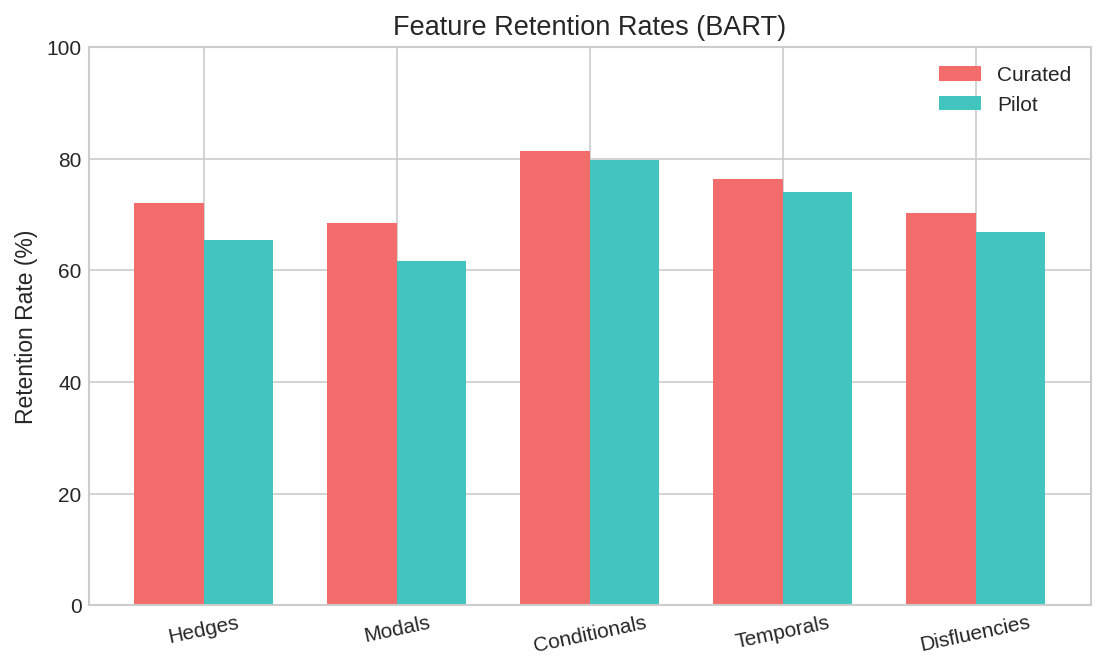

In [ ]:

# Replace these dicts with the actual values from your eval notebook
cur_rates = {"Hedges": 72.0, "Modals": 68.5, "Conditionals": 81.3, "Temporals": 76.4, "Disfluencies": 70.2}
pil_rates = {"Hedges": 65.4, "Modals": 61.7, "Conditionals": 79.8, "Temporals": 74.1, "Disfluencies": 66.9}

feature_order = ["Hedges", "Modals", "Conditionals", "Temporals", "Disfluencies"]
cur_vals = [cur_rates.get(f, 0) for f in feature_order]
pil_vals = [pil_rates.get(f, 0) for f in feature_order]

# --- colors (same as Pegasus chart) ---
CURATED_COLOR = "#F26C6C"   # coral/red
PILOT_COLOR   = "#42C5BE"   # teal

x = range(len(feature_order))
w = 0.36

plt.figure(figsize=(7.5,4.6), dpi=150)
plt.bar([i - w/2 for i in x], cur_vals, width=w, label="Curated", color=CURATED_COLOR)
plt.bar([i + w/2 for i in x], pil_vals, width=w, label="Pilot",   color=PILOT_COLOR)

plt.xticks(list(x), feature_order, rotation=12)
plt.ylim(0, 100)
plt.ylabel("Retention Rate (%)")
plt.title("Feature Retention Rates (BART)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()